# Strip Sampling on 2dising square lattice with Numba acceleration
## 332.83 seconds used for 1E6 steps of Chain Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [2]:
import copy
import time

In [3]:
import numba as nb

In [4]:
### fix the random seed
seed = 0
np.random.seed(seed)

-----------

In [5]:
global grids, dims, beta, j, h, delta

In [6]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grids, dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.int8(beta_init), nb.int8(j_init), nb.int8(h_init)
    grids = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [7]:
### initialize the parameters
dims_init = (10, 10)
beta_init, j_init, h_init = 7, -1, 0

In [8]:
parameters_init(dims_init, beta_init, j_init, h_init)

--------------

In [9]:
types_neibors_get = nb.int8[:, :](nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibors_get)
def neibors_get(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    neibors_array = np.zeros((6, 2), dtype=np.int8)
    neibors_array[0] = np.array([height_index, nb.int8((width_index - 1) % width)])
    neibors_array[1] = np.array([height_index, nb.int8((width_index + 1) % width)])
    neibors_array[2] = np.array([nb.int8((height_index - 1) % height), width_index])
    neibors_array[3] = np.array([nb.int8((height_index + 1) % height), width_index])          
    neibors_array[4] = np.array([nb.int8((height_index - 1) % height), 
                                 nb.int8((width_index + 1) % width)])
    neibors_array[5] = np.array([nb.int8((height_index + 1) % height), 
                                 nb.int8((width_index - 1) % width)])
    return neibors_array

In [10]:
type_energy_get_func = nb.int16(nb.int8[:, :], nb.int8[:, :], nb.int8)
@nb.njit(type_energy_get_func)
def energy_get(grids, id_neibors, spin):
    energy = 0
    num_neibors = id_neibors.shape[0]
    for i in range(num_neibors):
        energy += -j * spin * grids[id_neibors[i][0]][id_neibors[i][1]]
    energy += -h * spin
    return energy

In [11]:
type_message_on_node_func = nb.float64[:](nb.int8[:, :], nb.int8[:, :])
@nb.njit(type_message_on_node_func)
def message_on_node(grids, id_neibors):
    spin_up, spin_down = 1, -1
    energy_up = energy_get(grids, id_neibors, spin_up)
    energy_down = -energy_up
    message = np.array([np.exp(-beta * energy_up), 
                        np.exp(-beta * energy_down)])
    return message

In [12]:
type_message_on_edge_func = nb.float64[:, :]()
@nb.njit(type_message_on_edge_func)
def message_on_edge():
    """
    Args:
        edge: (tuple) (node_start, node_end)
            
    Returns:
        message: (np.array) 2x2 matrix
    """
    row_start_up = [np.exp(beta*j), np.exp(-1*beta*j)]
    row_start_down = [np.exp(-1*beta*j), np.exp(beta*j)]
    message = np.array([row_start_up, row_start_down])
    return message

In [13]:
type_dict_filter_func = nb.int8[:, :](nb.int8[:, :], nb.int8[:])
@nb.njit(type_dict_filter_func)
def dict_filter(neibors_array, index_array):
    num_indices = index_array.shape[0]
    neibors_sel = np.zeros((num_indices, 2), dtype=np.int8)
    for i in range(num_indices):
        neibors_sel[i] = neibors_array[index_array[i]]
    return neibors_sel

In [14]:
type_matmul_my_func = nb.float64[:](nb.float64[:], nb.float64[:, :])
@nb.njit(type_matmul_my_func)
def matmul_my(vector_t, matrix):
    len_vector_t = len(vector_t)
    vector_output = np.zeros(len_vector_t, dtype=np.float64)
    for i in range(len_vector_t):
        vector_output += vector_t[i] * matrix[i, :]
    return vector_output

In [15]:
type_chain_sampling_func = nb.types.Tuple((nb.int8[:, :], nb.float64[:, :], nb.int8))(nb.int8[:, :], 
                                                                                      nb.int8, 
                                                                                      nb.int8)
@nb.njit(type_chain_sampling_func)
def chain_sampling(grids, id_height, id_start):
    stack = np.zeros((dims[1]-1, 2), dtype=np.float64)
    id_end = nb.int8((id_start - 1) % dims[1])
    id_start = nb.int8((id_start + 1) % dims[1])
    if dims[1] > 2:
        id_neibors = neibors_get((id_height, id_start))
        index_array = np.array([0, 2, 3, 4, 5], dtype=np.int8)
        id_neibors = dict_filter(id_neibors, index_array)
    else:
        id_neibors = neibors_get((id_height, id_start))
    message_edge = message_on_edge()
    z_start = message_on_node(grids, id_neibors)
    stack[id_start, :] = z_start
    while id_start != id_end:
        id_start = nb.int8((id_start + 1) % dims[1])
        ###########################################
        #z_start = np.matmul(z_start, message_edge)
        # matrix multiplication is not supported, so we implement our own matmul function
        z_start = matmul_my(z_start, message_edge)
        ###########################################
        if id_start == id_end:
            id_neibors = neibors_get((id_height, id_start))
            index_array = np.array([1, 2, 3, 4, 5],dtype=np.int8)
            id_neibors = dict_filter(id_neibors, index_array)
        else:
            id_neibors = neibors_get((id_height, id_start))
            index_array = np.array([2, 3, 4, 5], dtype=np.int8)
            id_neibors = dict_filter(id_neibors, index_array)
        node_message = message_on_node(grids, id_neibors)
        z_start = z_start * node_message
        stack[id_start, :] = z_start
    z_start = stack[id_end]
    z_start_norm = z_start / np.sum(z_start)
    if np.random.random() < z_start_norm[0]:
        spin_start = nb.int8(1)
    else:
        spin_start = nb.int8(-1)
    grids[id_height][id_start] = spin_start
        
    return grids, stack, id_start

In [16]:
type_backtrack_sampling_func = nb.int8[:, :](nb.int8[:, :], nb.int8, nb.int8, nb.float64[:, :])
@nb.njit(type_backtrack_sampling_func)
def backtrack_sampling(grids, id_height, id_start, stack):
    message_edge = message_on_edge()
    #while len(stack) != 0:
    for _ in range(dims[1] - 2):
        id_start = nb.int8((id_start - 1) % dims[1])   
        neibors_array = neibors_get((id_height, id_start))
        index_array = np.array([1], dtype=np.int8)
        neibors_sel = dict_filter(neibors_array, index_array)
        message_node = message_on_node(grids, neibors_sel)
        z_start = message_node * stack[id_start]
        z_norm = z_start / np.sum(z_start)
        if np.random.random() < z_norm[0]:
            spin_start = 1
        else:
            spin_start = -1
        grids[id_height][id_start] = spin_start
    return grids

In [17]:
type_one_row_sampling_func = nb.int8[:, :](nb.int8[:, :], nb.int8)
@nb.njit(type_one_row_sampling_func)
def one_row_sampling(grids, id_height):
    #id_start = loop_sampling(id_height)
    id_start = np.random.randint(dims[1])
    grids, stack, id_start = chain_sampling(grids, id_height, id_start)
    grids = backtrack_sampling(grids, id_height, id_start, stack)
    return grids

In [18]:
type_chain_evol_one_step_func = nb.int8[:, :](nb.int8[:, :])
@nb.njit(type_chain_evol_one_step_func)
def chain_evolution_one_step(grids):
    for i in range(dims[0]-1):
        grids = one_row_sampling(grids, i) 
    grids = np.transpose(grids)
    for j in range(dims[1]-1):
        grids = one_row_sampling(grids, j)
    grids = np.transpose(grids)
    return grids

In [19]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibors_get((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [20]:
@nb.njit(nb.int32(nb.int8[:, :]))
def magnet_grids(grids):
    m_1, m_2, m_3 = 0, 0, 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            if (j + i) % 3 == 0:
                m_1 += grids[i][j]
            elif (j + i) % 3 == 1:
                m_2 += grids[i][j]
            else:
                m_3 += grids[i][j]
    m_square = np.square(m_1) + np.square(m_2) + np.square(m_3)
    return m_square

In [21]:
type_chain_evol_func = nb.types.Tuple((nb.int8[:, :], nb.float32[:], nb.float32[:]))(nb.int8[:, :], nb.int32)
@nb.njit(type_chain_evol_func)
def chain_evolution(grids, steps):
    energy_array = np.zeros(steps, dtype=np.float32)
    m_array = np.zeros(steps, dtype=np.float32)
    for i in range(steps):
        energy_array[i] = energy_compute_grids(grids)
        m_array[i] = magnet_grids(grids)
        grids = chain_evolution_one_step(grids)
    return grids, energy_array, m_array

In [22]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grids*np.pi/2)
    v = np.sin(grids*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

In [23]:
def spin_viz_dynamic(self, spins_list, file_name, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(spins_list[0]*np.pi/2)
    v = np.sin(spins_list[0]*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title(f'T={1/beta:.3f}, dims={dims}', fontsize=20)            
    def update_quiver(num, q):
        u = np.cos(spins_list[num+1]*np.pi/2)
        v = np.sin(spins_list[num+1]*np.pi/2)
        q.set_UVC(u, v)
        return q
    frames = len(spins_list) - 1
    anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                   fargs=(q, ), interval=50, repeat=False)
    writergif = animation.PillowWriter(fps=100) 
    anim.save(f'./{file_name}.gif', writer=writergif)

--------

In [24]:
grids

array([[-1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
       [ 1, -1, -1,  1, -1, -1, -1, -1, -1,  1],
       [-1,  1,  1, -1, -1,  1,  1,  1,  1, -1],
       [ 1, -1,  1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1, -1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1, -1,  1],
       [ 1, -1,  1, -1,  1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1,  1,  1, -1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1,  1, -1],
       [ 1,  1, -1, -1,  1, -1, -1,  1,  1, -1]], dtype=int8)

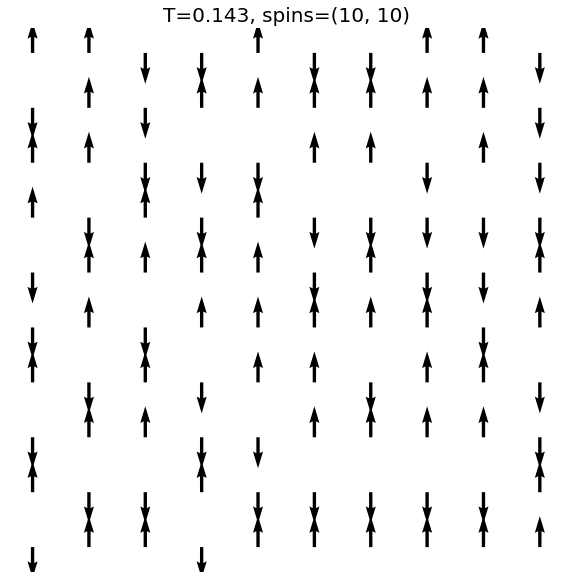

In [25]:
spin_viz()

In [26]:
time_start = time.time()
grids, energy_array, m_square_array = chain_evolution(grids, 100000)
time_end = time.time()
print(f"Time used for 1E6 steps is: {time_end-time_start}.")

Time used for 1E6 steps is: 32.460270404815674.


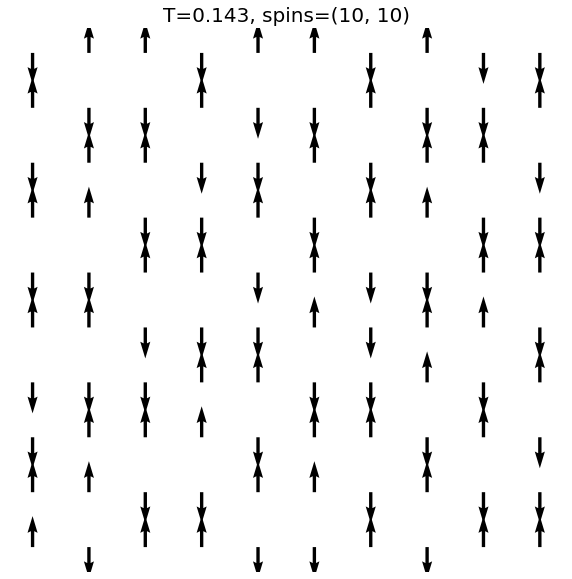

In [27]:
spin_viz()

Text(0.5, 1.0, 'Energy Series of Cluster Evoluation')

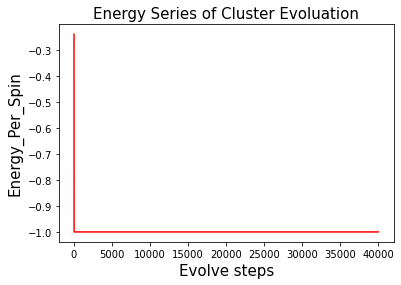

In [28]:
plt.plot(energy_array[:40000], '-r')
plt.xlabel("Evolve steps", fontsize=15)
plt.ylabel("Energy_Per_Spin", fontsize=15)
plt.title("Energy Series of Cluster Evoluation", fontsize=15)

Text(0.5, 1.0, 'Energy Series of Cluster Evoluation')

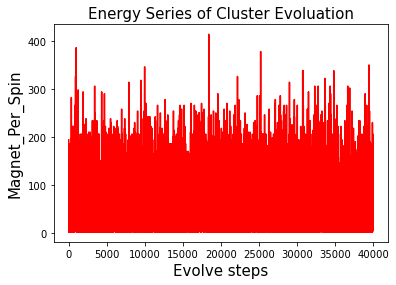

In [29]:
plt.plot(m_square_array[:40000], '-r')
plt.xlabel("Evolve steps", fontsize=15)
plt.ylabel("Magnet_Per_Spin", fontsize=15)
plt.title("Energy Series of Cluster Evoluation", fontsize=15)

----